[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaralAminpour/ML-BME-Course-UofA-Fall-2023/blob/main/week-9-CNN/9.1-CNNs.ipynb)


# Convolutional Neural Networks in Pytorch

The aim of this tutorial is to extend on what you learnt in Week 8 on basic Pytorch syntax for fully connected networks, and apply this to coding simple convolutional neural networks, or CNNs.

Import pytorch and all the libraries you will need

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

import tarfile
import zipfile
from pathlib import Path

import pandas as pd
import io
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



## Building blocks

The basic components of a convolutional neural networks are convolutional layers and downsampling operations. In this notebook we will downsample through max pooling.

### Convolutions

The convolutional operation works similarly to what you have previously seen for hand engineered localised feature descriptors such as the Gray level co-occurrence matrix (and Sobel, Laplacian and Gaussian filters).

These work by translating a hand engineered filter kernel across an image, at each position, multiplying each element of the filter with the element of the image that they overlap with. This operation is shown below for the vertical sobel edge filter, for the first filter location:

<img src="https://drive.google.com/uc?id=1gb2QaE8lW6GgNFwCEk5mJqP0Uo91xxn8" alt="Drawing" style="width: 100px;"/>

The second, translated one step to the right:

<img src="https://drive.google.com/uc?id=1gcsv7870kjTCwnUV043k2u4iM2uydzBn" alt="Drawing" style="width: 100px;"/>

This continues until the filter has been fit at all possible locations in the image. The final output of the convolution is another image:

<img src="https://drive.google.com/uc?id=1geRXevPNs_sSMeKWyEnEEKFszz3ptqcV" alt="Drawing" style="width: 100px;"/>

This will be slightly smaller than the input image by default, since it corresponds to all locations in the input image on which the filter can be centered. This excludes the outer rows and columns of the image.

By default however, Pytorch will return you an image of the same size by using padding:

<img src="https://drive.google.com/uc?id=1ggS0vucaH_mM9X1aBTRX4lSEDnZlmyZg" alt="Drawing" style="width: 100px;"/>

**The key difference between CNNs and traditional filters is that CNNs learn the best filters for a specific feature recognition problem, whereas traditional feature detectors are hand engineered.**

### Max pooling

The next most important component of a CNN is downsampling. Downsampling allows a CNN to increase its _receptive field_ :

<img src="https://drive.google.com/uc?id=1gV1ZqsV5JGkWys5H0bDcnw9pgR-EYtvf" alt="Drawing" style="width: 100px;"/>

<img src="https://drive.google.com/uc?id=1gYKvI9ULXFhdyHSGp4XoUmyMFmCijbsI" alt="Drawing" style="width: 100px;"/>

As you saw in the previous section, the filter kernels themselves are small. The only way the network can 'see' the full context of the image is by aggregating across layers, and by downsampling at regular intervals. This way, as you go through the network the filters will learn more and more complex textures, at larger scales, until they can recognise whole objects.



## Coding CNNs in Pytorch

You already saw last week how to set up a basic fully connected network, choose a cost function and write a training loop. All this stays the same for CNNs. All you need in addition is convolutional and max pool layers.

In PyTorch, A 2D convolution class is defined within the `torch.nn` module as follows:

<img src="https://drive.google.com/uc?id=12hvQSk-kCsPWTnEE16KKPkA0zo1R3Wzc" alt="Drawing" style="width: 800px;"/>

And the maxpool function in pytorch is [```nn.MaxPool2d```](https://pytorch.org/docs/stable/nn.html?highlight=maxpool#torch.nn.MaxPool2d).

## Exercise 1 - MedMNIST Example

In this first example we will use a dataset known as MedMNIST. Its name is inspired by the MNIST dataset, which was the original benchmark used to train CNNs. MNIST contains a large dataset of images of handwritten digits (0-9). MedMNIST collates several X-Ray datasets and standardizes them to the same size. In this example, we will select hand images, chest CT images, abdomen CT images and head CT images, only. Each class has 10000 images. We will use 800 for training, 100 for validation, and 100 for testing.


**Task 1.1** run all these code blocks and make sure you understand what they are doing:
- Setting the device
- Pushing the network and data to the device
- Converting data to torch tensors of correct types
- Creating network layers of an appropriate size
- Choosing suitable losses


Make sure to check which device you are running on - should be GPU

In [ ]:
# This will allow the network to run on GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(device)

cuda


Then download the data

In [ ]:
# This block of code will download the MedNIST dataset and extract it to the current directory

# Download MedNIST dataset
!curl -L -o MedNISTSmall.tar.gz 'https://github.com/irinagrigorescu/tempmri/raw/main/MedNISTSmall.tar.gz'

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open("MedNISTSmall.tar.gz")
datafile.extractall()
datafile.close()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4109k  100 4109k    0     0  2858k      0  0:00:01  0:00:01 --:--:-- 26.4M


Anf then select a subset for train, validation and test

In [ ]:
# Get data
data_dir = Path('./MedNISTSmall/')
# class_names = sorted([p.stem for p in data_dir.iterdir() if p.is_dir()])

# Choose image files from the four classes below
class_names = ['Hand', 'ChestCT', 'HeadCT', 'AbdomenCT']
image_files = [[x for x in (data_dir / class_name).iterdir()] for class_name in class_names]

# Create a training / validation / testing split for the images
# 800 hand + 800 chest + 800 head + 800 abdomen        TRAIN
dataset_train = image_files[0][:800] + image_files[1][:800] + image_files[2][:800] + image_files[3][:800]

# 100 hand + 100 chest + 100 head + 100 abdomen        VALIDATION
dataset_valid = image_files[0][800:900] + image_files[1][800:900] + image_files[2][800:900] + image_files[3][800:900]

# 100 hand + 100 chest + 100 head + 100 abdomen        TEST
dataset_test  = image_files[0][900:] + image_files[1][900:] + image_files[2][900:] + image_files[3][900:]

# Create a training / validation / testing split for the labels
labels_train = ["hand"] * 800 + ["chest"] * 800 + ["head"] * 800 + ["abdomen"] * 800
labels_valid = ["hand"] * 100 + ["chest"] * 100 + ["head"] * 100 + ["abdomen"] * 100
labels_test = ["hand"] * 100 + ["chest"] * 100 + ["head"] * 100 + ["abdomen"] * 100

print('train', len(dataset_train), len(labels_train))
print('valid', len(dataset_valid), len(labels_valid))
print('test ', len(dataset_test), len(labels_test))

train 3200 3200
valid 400 400
test  400 400


Let's visualise a few of these to see what they look like:

**Task 1.2**

- Change ```i``` to different values to view different images from the training set (there are 3200)
- Print the labels: you'll notice they are currently words - we will need integers ```y={0,1,2..}```


hand


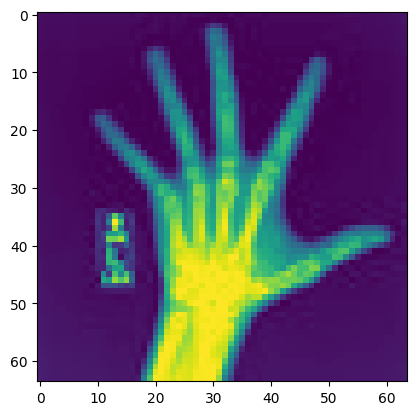

In [ ]:
i=100

example_image=np.array(Image.open(dataset_train[i]))

# plot image
plt.imshow(example_image)
# print its label
print(labels_train[i])

Now we'll set up our train, test and validation sets as torch tensors. This will require:

1. Reading in each image as a .jpg file using the PIL library (imported above)
2. Normalising each image into the range 0 to 1 (to standardise each image into a constant range)
3. Combining all images into one 3D array of shape (n_examples, image_height, image_width)
4. Converting the array to a torch tensor of type float


In [ ]:
def convert_to_torch_tensor(dataset):
  ''' takes list of image paths and reads them into an array;
      converts to tensor '''
  image_list=[]

  for image_path in dataset:
    # Read in each jpeg and convert to array,
    image=np.array(Image.open(image_path))
    # Normalise into range 0-1
    if np.max(image)-np.min(image) !=0:
      image=(image-np.min(image))/(np.max(image)-np.min(image))

    # Read into list
    image_list.append(image)

  # Convert list to np array
  image_array=np.asarray(image_list)

  # Convert numpy array to torch tensor with added dimension corresponding to the number of channels (1)
  torch_tensor=torch.from_numpy(np.expand_dims(image_array,axis=1)).to(torch.float)
  return torch_tensor

# Create torch tensors for train, validation and test
X_train=convert_to_torch_tensor(dataset_train)
X_valid=convert_to_torch_tensor(dataset_valid)
X_test=convert_to_torch_tensor(dataset_test)

print('train shape', X_train.shape)
print('valid shape', X_valid.shape)
print('test shape ', X_test.shape)

train shape torch.Size([3200, 1, 64, 64])
valid shape torch.Size([400, 1, 64, 64])
test shape  torch.Size([400, 1, 64, 64])


Finally (in terms of preprocessing) we need to converting our labels from text to integer labels

In [ ]:
LABEL_MAPPING = {"hand": 0, "chest": 1, "head": 2, "abdomen": 3}

def convert_labels(label_list):
  ''' will loop throuhg all labels and convert to integers'''
  label_ids=[]

  for lb in label_list:
    label_ids.append(LABEL_MAPPING[lb])

  labels_tensor=torch.from_numpy(np.asarray(label_ids)).to(torch.long)

  return labels_tensor

# Create torch tensors for train, validation and test
y_train=convert_labels(labels_train)
y_valid=convert_labels(labels_valid)
y_test=convert_labels(labels_test)

print('train labels', y_train)

train labels tensor([0, 0, 0,  ..., 3, 3, 3])


Now that we have our data in the right format we need to set up our network:
- Layers must be defined in the ```__init__``` function
- The forward pass is defined in the ```forward``` function
- The backwards pass is taken care of automatically
- Once set up, we push the network to the device

*Architecture:*
- Four convolutional layers, each fitting 3x3 filter kernels with same convolution
- Two linear layers

**Task 1.3** input the number of input neurons of the first linear layer (set ``fc1_input_dim``)

- *Hint:* if the images start as $64\times64$ and you downsample 4 times (once for each convolutional layer) by a factor of 2, what will be the output dimensions of the final convolutional layer? Note that it must be flattened.
- Don't forget the channel dimension!
- If you are stuck, add print statements between the layers and get the code interpreter to do the work for you.

In [ ]:
class MedNet(nn.Module):

    def __init__(self, flattened_dim):
        super(MedNet,self).__init__()

        # The syntax to define the convolutional layers is:
          # nn.Conv2d(channels in, channels out, filter size)

        # For layer 1:
                      # channels in = 1 (input has 1 channel - greyscale)
                      # channels out = 8 (hyperparameter - you can try different values here)
                      # the filter kernel size is 3
                      # padding is set to True (or same)
        self.conv1 = nn.Conv2d(1, 8, 3, padding='same')

        # For layer 2:
                      # channels in = 8 (equal to the output channel dimension of the previous layer)
                      # channels out = 16 (hyperparameter - you can try different values here)
        self.conv2 = nn.Conv2d(8, 16, 3, padding='same')

        # For layer 3:
                      # channels in = 16
                      # channels out = 32 (hyperparameter - you can try different values here)
        self.conv3 = nn.Conv2d(16, 32, 3, padding='same')

        # For layer 4:
                      # channels in = 32
                      # channels out = 48 (hyperparameter - you can try different values here)
        self.conv4 = nn.Conv2d(32, 48, 3, padding='same')

        # Max pooling kernel of size 2x2
        self.pool = nn.MaxPool2d(2, 2)

        # The syntax to define the linear layers is:
          # nn.Linear(nodes in, nodes out)

        # The first linear layer will have input dimensions equal to the length of the flattened output from conv2
        # The output dimensions are a hyperparameter - we choose 25
        self.ful1 = nn.Linear(flattened_dim, 25)

        # The second linear layer will have input dimensions equal to the output of the first linear layer
        # The output will be equal to the number of classes (here 4)
        self.ful2 = nn.Linear(25, 4)


    def forward(self,x):
        # Here we put the layers together, implementing ReLU activations after each weight learning layer
        # First convolutional layer followed by ReLU, then pooling:
        x = self.pool(F.relu(self.conv1(x)))

        # Second convolutional layer + ReLU and pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Third convolutional layer + ReLU and pooling
        x = self.pool(F.relu(self.conv3(x)))

        # Fourth convolutional layer + ReLU and pooling
        x = self.pool(F.relu(self.conv4(x)))

        # The last activation map is flattened:
        x = torch.flatten(x, 1) # flatten all dimensions except batch

        # x is then passed through one linear layer with input dims equal to the flattened dims
        x = F.relu(self.ful1(x))

        # And a second linear layer with output dim equal to the number of classes
        x = self.ful2(x)

        return x


fc1_input_dim = None  # Complete this line of code #

# Push the network to the device
net = MedNet(fc1_input_dim).to(device)

Next we must define our losses and our choice of optimiser. Here, as it is a classifier, we implement cross entropy loss. We will use the ``SGD`` (stochastic gradient descent) optimiser.

In [ ]:
loss_fun = nn.CrossEntropyLoss()
loss_fun = loss_fun.to(device) # send to device

# Note the optimiser takes the network as an argument
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

On momentum: "The momentum method (Polyak,1964), which we refer to as classical momentum (CM) is a technique for accelerating gradient descent that accumulates a velocity vector in directions of persistent reduction in the objective across iterations." from: http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf.

Run training and validation and plot losses

**Note:** here we pass all training examples in a single block. More generally, in DL, the data set is too large for this and you have to pass batches.

torch.Size([3200, 48, 4, 4])
torch.Size([400, 48, 4, 4])
Train loss : 0.0184, Val Loss: 0.0329, Val accuracy: 0.9900
torch.Size([3200, 48, 4, 4])
torch.Size([400, 48, 4, 4])
Train loss : 0.0183, Val Loss: 0.0328, Val accuracy: 0.9900
torch.Size([3200, 48, 4, 4])
torch.Size([400, 48, 4, 4])
Train loss : 0.0182, Val Loss: 0.0327, Val accuracy: 0.9900
torch.Size([3200, 48, 4, 4])
torch.Size([400, 48, 4, 4])
Train loss : 0.0182, Val Loss: 0.0326, Val accuracy: 0.9900
torch.Size([3200, 48, 4, 4])
torch.Size([400, 48, 4, 4])
Train loss : 0.0181, Val Loss: 0.0325, Val accuracy: 0.9900
torch.Size([3200, 48, 4, 4])
torch.Size([400, 48, 4, 4])
Train loss : 0.0180, Val Loss: 0.0324, Val accuracy: 0.9900
torch.Size([3200, 48, 4, 4])
torch.Size([400, 48, 4, 4])
Train loss : 0.0179, Val Loss: 0.0324, Val accuracy: 0.9900
torch.Size([3200, 48, 4, 4])
torch.Size([400, 48, 4, 4])
Train loss : 0.0179, Val Loss: 0.0323, Val accuracy: 0.9900
torch.Size([3200, 48, 4, 4])
torch.Size([400, 48, 4, 4])
Train l

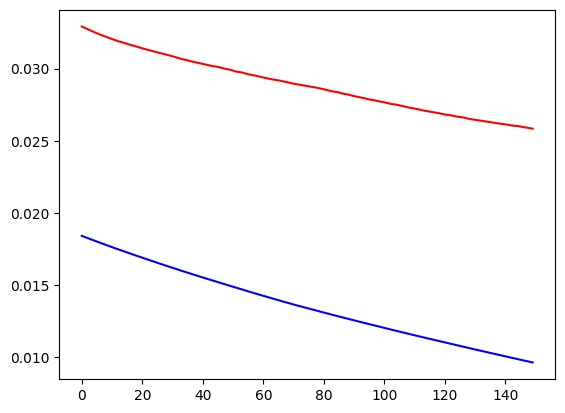

In [ ]:
from sklearn.metrics import accuracy_score

epochs = 150
accuracy = []
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Set network to training mode
    net.train()

    # Perform a training loop
    data = X_train.to(device)
    label = y_train.to(device)

    # Clear the gradients
    optimizer.zero_grad()

    # Feed the input and acquire the output from network
    x_out = net(data)

    # Calculate the loss
    err = loss_fun(x_out, label)
    train_losses.append(err)

    # Compute the gradient
    err.backward()

    # Update the parameters
    optimizer.step()

    with torch.no_grad():
      net.eval()

      valdata = X_valid.to(device)
      vallabel = y_valid.to(device)
      x_out = net(valdata)
      val_err = loss_fun(x_out, vallabel)
      val_losses.append(val_err)
      pred = x_out.data.max(1)[1].cpu() # Get the index of the max log-probability
      accuracy.append(accuracy_score(y_valid, pred))

      print('Train loss : {:.4f}, Val Loss: {:.4f}, Val accuracy: {:.4f}'.format(err, val_err,accuracy[-1]))

print(['Best val error: ', np.min(accuracy)])

# This step is needed to manipulate lists of tensors from the gpu device locally with numpy.
# Try printing train_losses and val_losses before this step to understand why that's needed.
train_losses = [tl.cpu().detach().numpy() for tl in train_losses]
val_losses = [vl.cpu().detach().numpy() for vl in val_losses]

# Plot the losses
plt.plot(np.arange(len(train_losses)),train_losses,'b')
plt.plot(np.arange(len(train_losses)),val_losses,'r')
plt.show()

**Task 1.4** try changing some of the training hyperparameters like the learning rate and number of epochs.

Now apply to the test set and report the accuracy you obtain.

In [ ]:
net.eval()

testdata = X_test.to(device)
testlabel = y_test.to(device)
x_out = net(testdata)

pred = x_out.data.max(1)[1].cpu() # Get the index of the max log-probability
print('test accuracy', accuracy_score(y_test, pred))

torch.Size([400, 48, 4, 4])
test accuracy 0.9925


## Exercise 2 - Regression of age at birth from brain scans

In this exercise, we will apply what we have learnt to build a network for regression. The data set will be images of axial brain slices from the Developing Human Connectome Project.

In [ ]:
import pandas as pd

# This code will download and unzip the required data files from GitHub
import requests
import os
def download_data(source, dest):
    base_url = 'https://raw.githubusercontent.com/'
    owner = 'MaralAminpour'
    repo = 'ML-BME-Course-UofA-Fall-2023'
    branch = 'main'
    url = '{}/{}/{}/{}/{}'.format(base_url, owner, repo, branch, source)
    r = requests.get(url)
    f = open(dest, 'wb')
    f.write(r.content)
    f.close()

# Create the temp directory, if it doesn't already exist
if not os.path.exists('temp'):
   os.makedirs('temp')

# Download the data folder
download_data('week-9-CNN/data_week9.zip', 'temp/data_week9.zip')

# Unzip the folder
if not os.path.exists('temp/mridata'):
    !pip install patool
    import patoolib
    patoolib.extract_archive('temp/data_week9.zip', outdir='temp/')


# Read the labels for training, test, and validation sets
# The .csv files contain 2 labels for each image (age at birth and age at scan)
meta_train = pd.read_csv('temp/data_train.csv')
meta_valid = pd.read_csv('temp/data_valid.csv')
meta_test = pd.read_csv('temp/data_test.csv')

# Let's start with just looking at the age at scan
y_train = torch.from_numpy(meta_train.iloc[:,2].values).to(torch.float)
y_valid = torch.from_numpy(meta_valid.iloc[:,2].values).to(torch.float)
y_test = torch.from_numpy(meta_test.iloc[:,2].values).to(torch.float)

print('number of train samples', len(y_train))
print('number of validation samples', len(y_valid))
print('number of test samples', len(y_test))



number of train samples 324
number of validation samples 32
number of test samples 40


Now let's plot a few examples.

**Task 2.1** change i and look at some of the images.

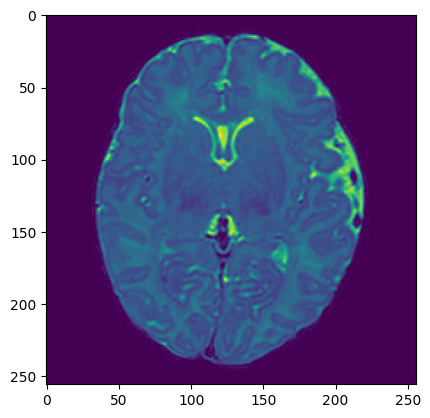

In [ ]:
i = 0
full_path = 'temp/mridata/'
image_path = os.path.join(full_path, meta_train['image_name'][i])
image=np.array(Image.open(image_path))

plt.imshow(image)
plt.show()

Now read in all files from each of the training, validation, and test sets.

In [ ]:
def load_data(path, meta):
  ''' load all the files for each data set '''
  image_list = []

  for iter, row in meta.iterrows():
    image_path=os.path.join(full_path, row['image_name'])
    image = np.array(Image.open(image_path))

    # Normalise to range 0-1
    if np.max(image)-np.min(image) !=0:
      image=(image-np.min(image))/(np.max(image)-np.min(image))

    # Append to image list
    image_list.append(image)

  # Convert list to numpy array
  image_array = np.asarray(image_list)

  # Convert numpy array to torch tensor with added dimension corresponding to the number of channels (1)
  torch_tensor = torch.from_numpy(np.expand_dims(image_array,axis=1)).to(torch.float)
  return torch_tensor


X_train = load_data(full_path,meta_train)
X_valid = load_data(full_path,meta_valid)
X_test = load_data(full_path,meta_test)

print('train shape', X_train.shape)
print('valid shape', X_valid.shape)
print('train shape', X_test.shape)

train shape torch.Size([324, 1, 256, 256])
valid shape torch.Size([32, 1, 256, 256])
train shape torch.Size([40, 1, 256, 256])


**Task 2.2** create your network.

- Try different network architectures using at least 3 convolutional layers and 2 fully connected layers
- **Hint** you can start by trying the network architecture we used in Exercise 1:
   - Remember to change the dimensions of the flattened data for the first fully connected layer!
   - Since this is a regression task, the output dimension will be 1
- Try this and then try changing your network design.

In [ ]:
# Task 2.2 create your network
class dHCPNet(nn.Module):

    def __init__(self,flattened_dim):
        super(dHCPNet,self).__init__()

        # Add your code here #


    def forward(self,x):
        # Add your code here #
        return x

fc1_input_dim=16*16*48
net = dHCPNet(fc1_input_dim).to(device)

**Task 2.3** set a suitable loss function and optimiser

- This time we have a regression problem, not a classification.
- Don't forget to push the loss to the device and the network parameters as input to the optimiser
- For the optimiser, you can try SGD or ADAM
- **Hint:** for SGD, reduce the learning rate down to 0.00001

In [ ]:
# Task 2.3 choose suitable loss and optimiser
# Add your code here #

**Task 2.4** complete training and validation loop.

**Note:** we've started this for you to show that the output of the network needs to be squeezed down to 1 dimension to compare it with the labels.

Iter: 0, Train loss : 1667.7078, Val Loss: 1661.3289
Iter: 1, Train loss : 1667.3978, Val Loss: 1660.8733
Iter: 2, Train loss : 1666.9387, Val Loss: 1660.4294
Iter: 3, Train loss : 1666.4933, Val Loss: 1659.8669
Iter: 4, Train loss : 1665.9294, Val Loss: 1659.1960
Iter: 5, Train loss : 1665.2572, Val Loss: 1658.4265
Iter: 6, Train loss : 1664.4861, Val Loss: 1657.5664
Iter: 7, Train loss : 1663.6243, Val Loss: 1656.6221
Iter: 8, Train loss : 1662.6779, Val Loss: 1655.5981
Iter: 9, Train loss : 1661.6519, Val Loss: 1654.5017
Iter: 10, Train loss : 1660.5531, Val Loss: 1653.3444
Iter: 11, Train loss : 1659.3933, Val Loss: 1652.1130
Iter: 12, Train loss : 1658.1595, Val Loss: 1650.8059
Iter: 13, Train loss : 1656.8497, Val Loss: 1649.4192
Iter: 14, Train loss : 1655.4598, Val Loss: 1647.9474
Iter: 15, Train loss : 1653.9851, Val Loss: 1646.3831
Iter: 16, Train loss : 1652.4176, Val Loss: 1644.7168
Iter: 17, Train loss : 1650.7477, Val Loss: 1642.9365
Iter: 18, Train loss : 1648.9637, Val 

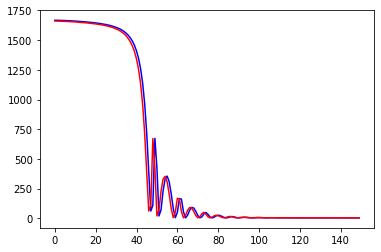

In [ ]:
epochs = 150
train_losses=[]
val_losses=[]

for epoch in range(epochs):
    # Set network to train mode
    net.train()
    # Perform a training loop
    data = X_train.to(device)
    label = y_train.to(device)
    # Clear the gradients
    optimizer.zero_grad()

    # Feed the input and acquire the output from network
    x_out = net(data)
    x_out = x_out.squeeze(1)

    # Task 2.3: finish the train and validation loop
    # Add your code here #

plt.plot(np.arange(len(train_losses)),train_losses,'b')
plt.plot(np.arange(len(train_losses)),val_losses,'r')
plt.show()


**Task 2.5** Apply to the test set.



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


test error is:  tensor(3.2965, device='cuda:0', grad_fn=<MseLossBackward0>)


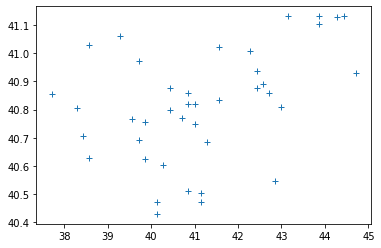

In [ ]:
# Add your code here #